# 6.6 Sourcing & Analyzing Time Series Data

### This script contains the following
#### 01. Importing Libraries & Data
#### 02. Subsetting, Wrangling, and Cleaning Time Series Data
#### 03. Time Series Analysis - Decomposition
#### 04. Testing for Stationarity
#### 05. Stationarizing Data

## Importing Libraries & Data

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. 

In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'kiMLQR1uPK4dNu4EXTAy'

In [4]:
# Importing the Zillow Real Estate Data for King County Regions
data = quandl.get_table('ZILLOW/DATA', indicator_id='ZSFH', region_id=['99693', '99637', '99618', '99614', '99613', '99608',
        '99607', '99605', '99598', '99591', '99590', '99584', '99577', '99564', '99561', '99559', '99554', '99550', '99548',
        '99547', '99546', '99541', '99539', '99537', '99535', '99533', '99532', '99531', '99529', '99525', '99524', '99523',
        '99517', '99513', '99512', '99509', '99507', '99504', '99502', '99498', '99491'], paginate=True)

In [5]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99693,2023-06-30,408740.044954
1,ZSFH,99693,2023-05-31,404173.615907
2,ZSFH,99693,2023-04-30,402335.252630
3,ZSFH,99693,2023-03-31,428386.045372
4,ZSFH,99693,2023-02-28,427202.540592


In [6]:
data.shape

(12637, 4)

In [7]:
data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

## Subsetting, Wrangling, & Cleaning Time Series Data

In [9]:
# Dropping unneccessary columns 'indicator_id' and 'region_id'
data_2 = data.drop(['indicator_id', 'region_id'], axis=1)

In [10]:
data_2.head()

,date,value
None,,
0,2023-06-30,408740.044954
1,2023-05-31,404173.615907
2,2023-04-30,402335.252630
3,2023-03-31,428386.045372
4,2023-02-28,427202.540592


In [24]:
# Since my data set imported with an index it is not necessary to reset the index
# Create new subset for relevant dates May 2014 - May 2015
data_sub = data_2.loc[(data_2['date'] >= '2014-05-31') & (data_2['date'] <= '2016-05-31')]

# needed to include data through 2016 in order to move through decomposition - needs at least 24 values

In [25]:
data_sub.head()

,date,value
None,,
85,2016-05-31,238255.0
86,2016-04-30,233302.0
87,2016-03-31,227540.0
88,2016-02-29,225074.0
89,2016-01-31,223517.0


In [26]:
data_sub.shape

(1000, 2)

In [27]:
# Setting the date as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['date']) # Create a datetime column from "date".
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['date'], axis=1, inplace=True) # Drop the "date" column.
data_sub.head()

,value
datetime,
2016-05-31,238255.0
2016-04-30,233302.0
2016-03-31,227540.0
2016-02-29,225074.0
2016-01-31,223517.0


In [42]:
data_sub2 = data_sub.groupby('datetime').agg({'value': ['mean']})

In [43]:
data_sub2.head(25)

,value
,mean
datetime,
2014-05-31,441367.225
2014-06-30,445018.200
2014-07-31,446677.350
2014-08-31,448487.775
2014-09-30,449556.400
2014-10-31,452706.375
2014-11-30,456355.100
2014-12-31,459946.750


In [45]:
data_sub2.shape

(25, 1)

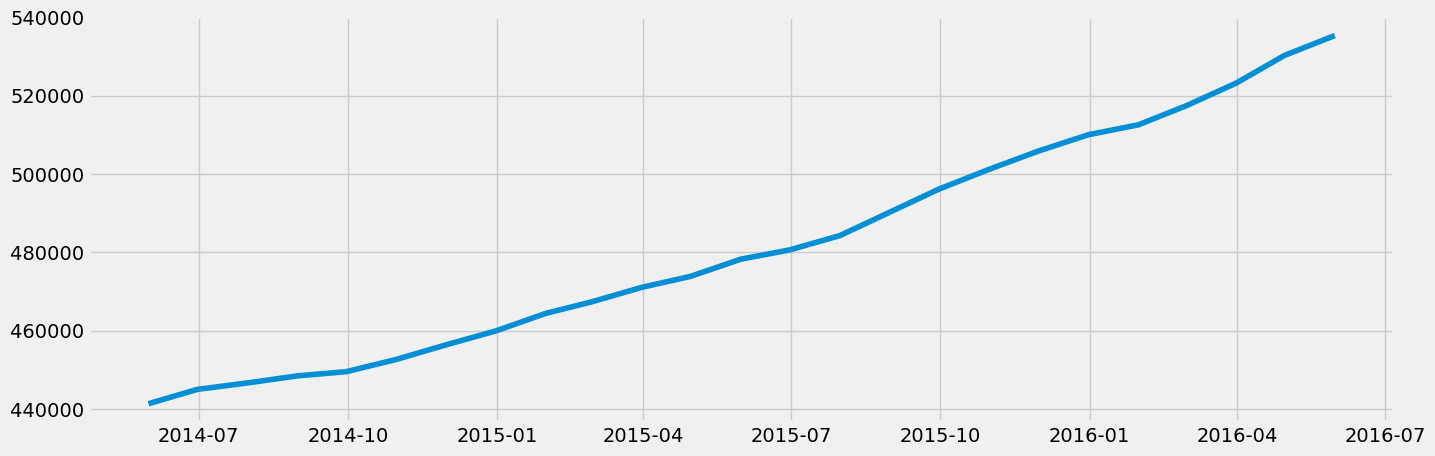

In [29]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data_sub2)

In [36]:
# Check for missing values 

data_sub2.isnull().sum() 

0

In [37]:
# Check for duplicates

dups = data_sub2.duplicated()
dups.sum()

# No dups

0

## Time Series Analysis - Decomposition

In [30]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub2, model='additive')

In [31]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

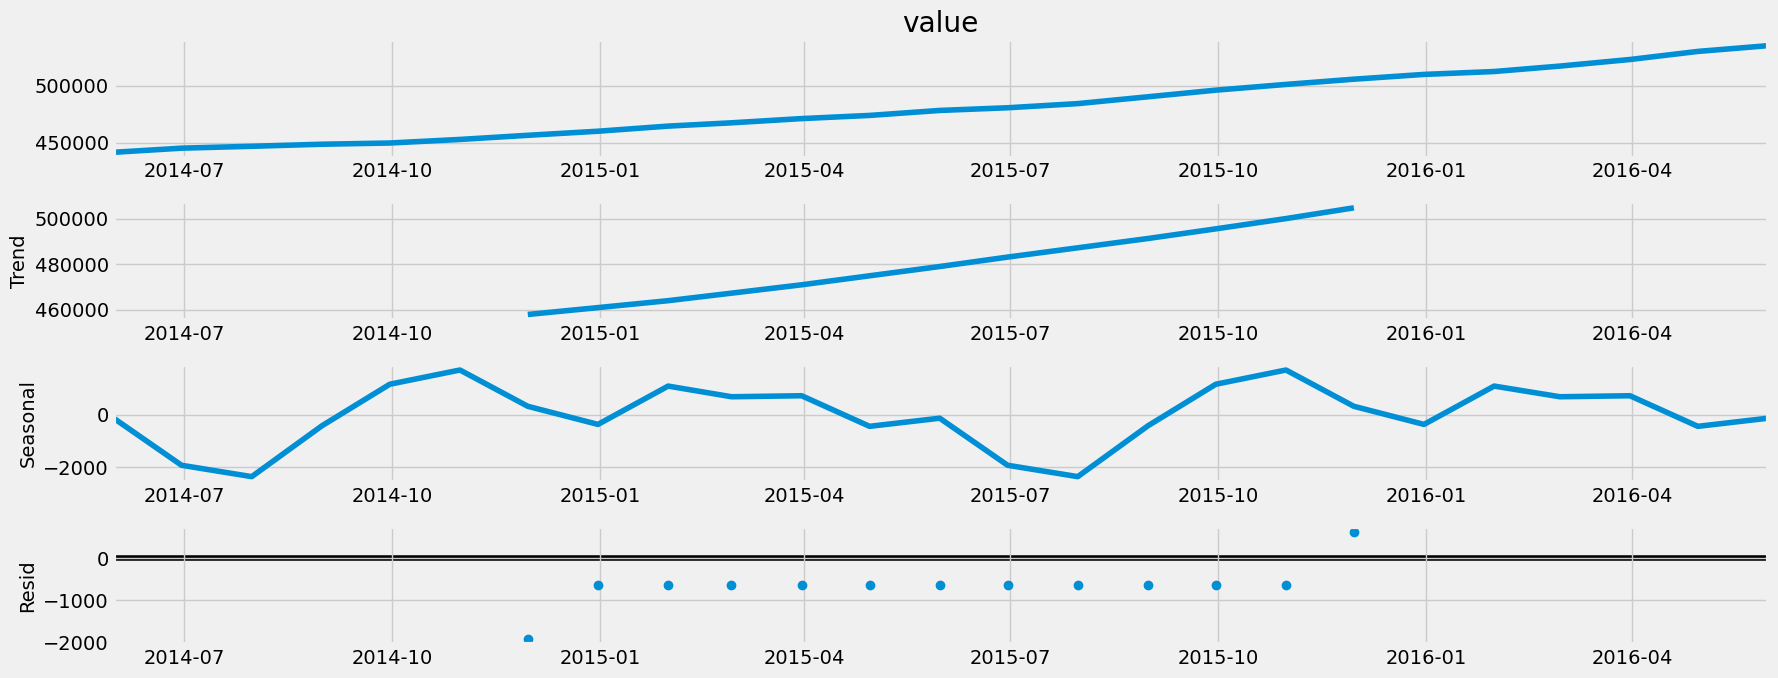

In [32]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Interpreting Results
The trend shows an increase in house sale values over time. There is also some seasonality with house sale values dropping after June and peaking around November while remaining fairly steady throught the other months. Since this data did not need to be smoothed, there isn't any unexplained noise.

## Testing for Stationarity

In [56]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub2['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  1.772609
p-value                         0.998293
Number of Lags Used             8.000000
Number of Observations Used    16.000000
Critical Value (1%)            -3.924019
Critical Value (5%)            -3.068498
Critical Value (10%)           -2.673893
dtype: float64


#### Interpreting Results
Since the test statistic is larger than than the critical value the null hypothis cannot be rejected

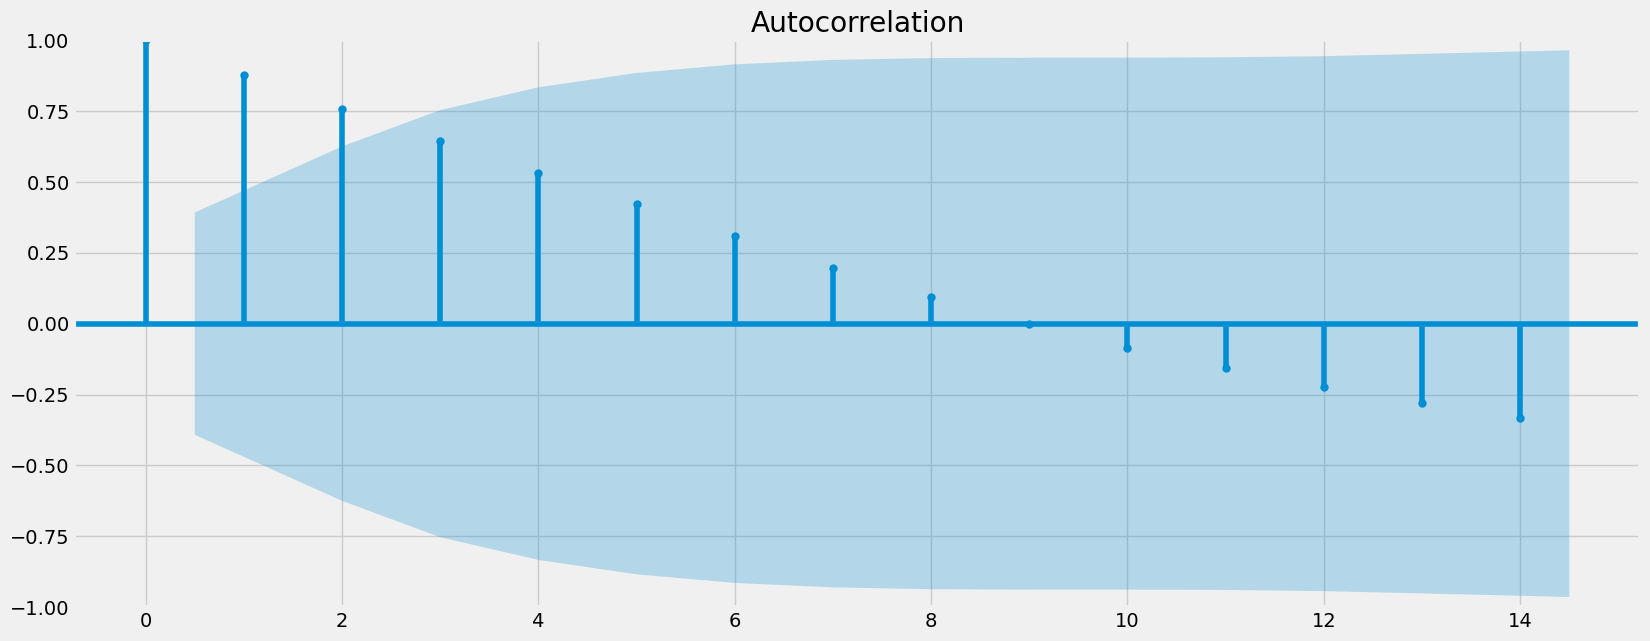

In [57]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub2)
plt.show()

## Stationarizing Data

In [48]:
data_diff = data_sub2 - data_sub2.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [49]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 

In [52]:
data_diff.head()

,value
,mean
datetime,
2014-06-30,3650.975
2014-07-31,1659.150
2014-08-31,1810.425
2014-09-30,1068.625
2014-10-31,3149.975


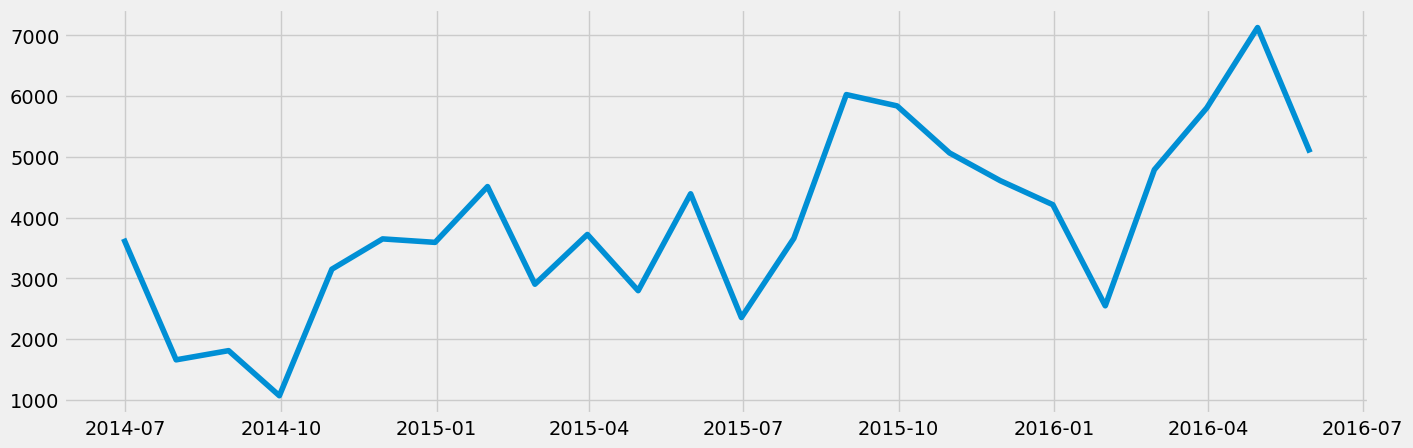

In [53]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [64]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -0.581944
p-value                         0.875010
Number of Lags Used             9.000000
Number of Observations Used    14.000000
Critical Value (1%)            -4.012034
Critical Value (5%)            -3.104184
Critical Value (10%)           -2.690987
dtype: float64


#### Interpreting Results
The test statistic is still larger than the critical value. Further differencing is required.

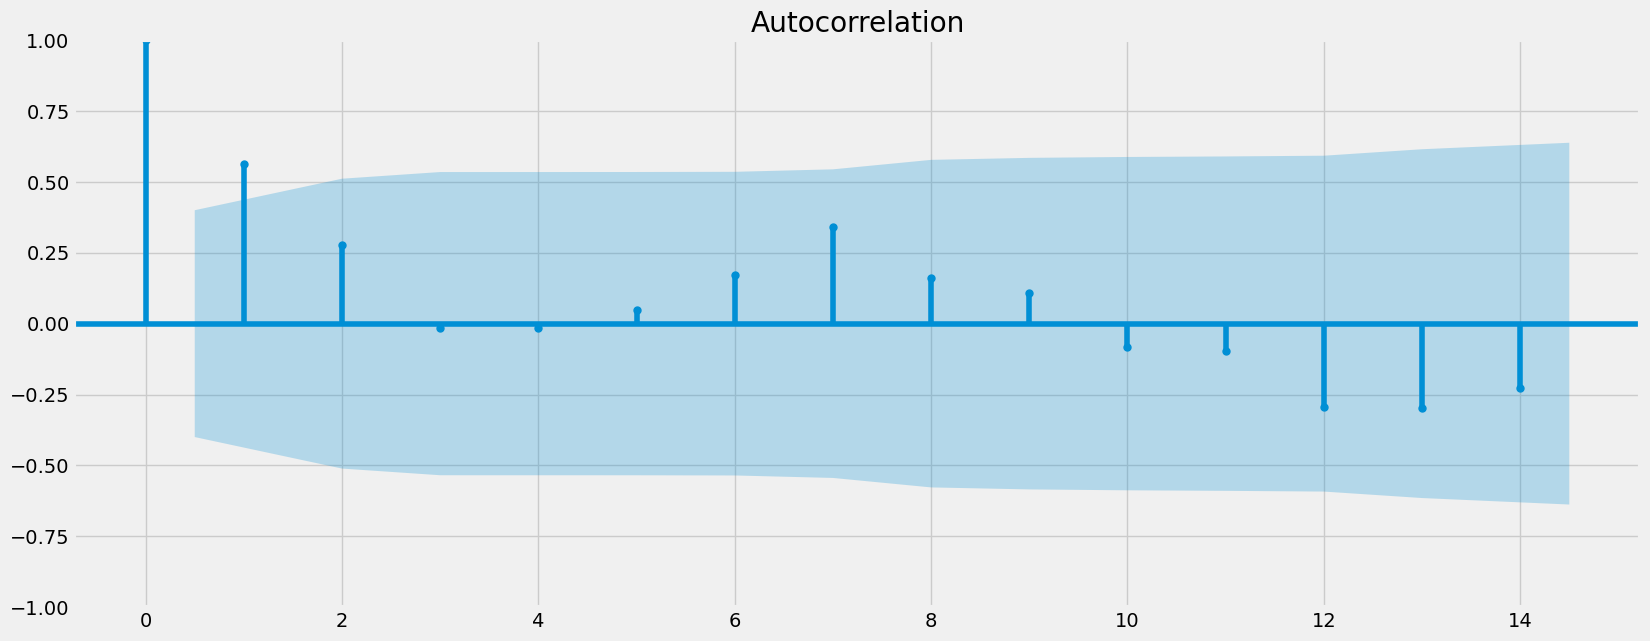

In [55]:
plot_acf(data_diff)
plt.show()

In [58]:
# Performing another round of differencing
data_diff2 = data_diff - data_diff.shift(1)

In [59]:
data_diff2.dropna(inplace = True)

In [60]:
data_diff2.head()

,value
,mean
datetime,
2014-07-31,-1991.825
2014-08-31,151.275
2014-09-30,-741.800
2014-10-31,2081.350
2014-11-30,498.750


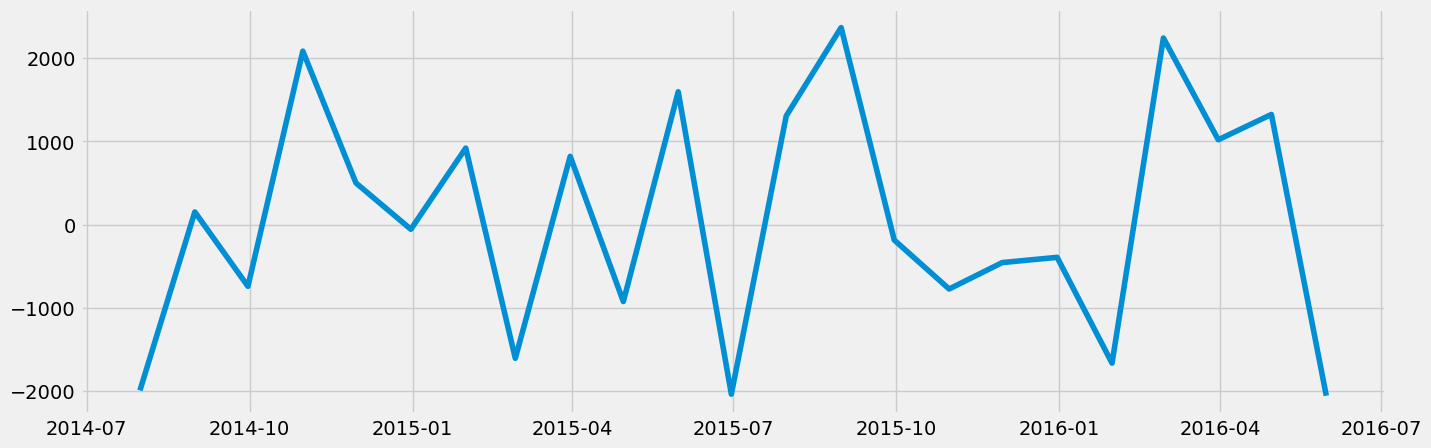

In [61]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [62]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.963296
p-value                         0.001615
Number of Lags Used             9.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


#### Interpreting Results
The test statistic is smaller than the critical value (5%) therefore we can now reject the null hypothesis.

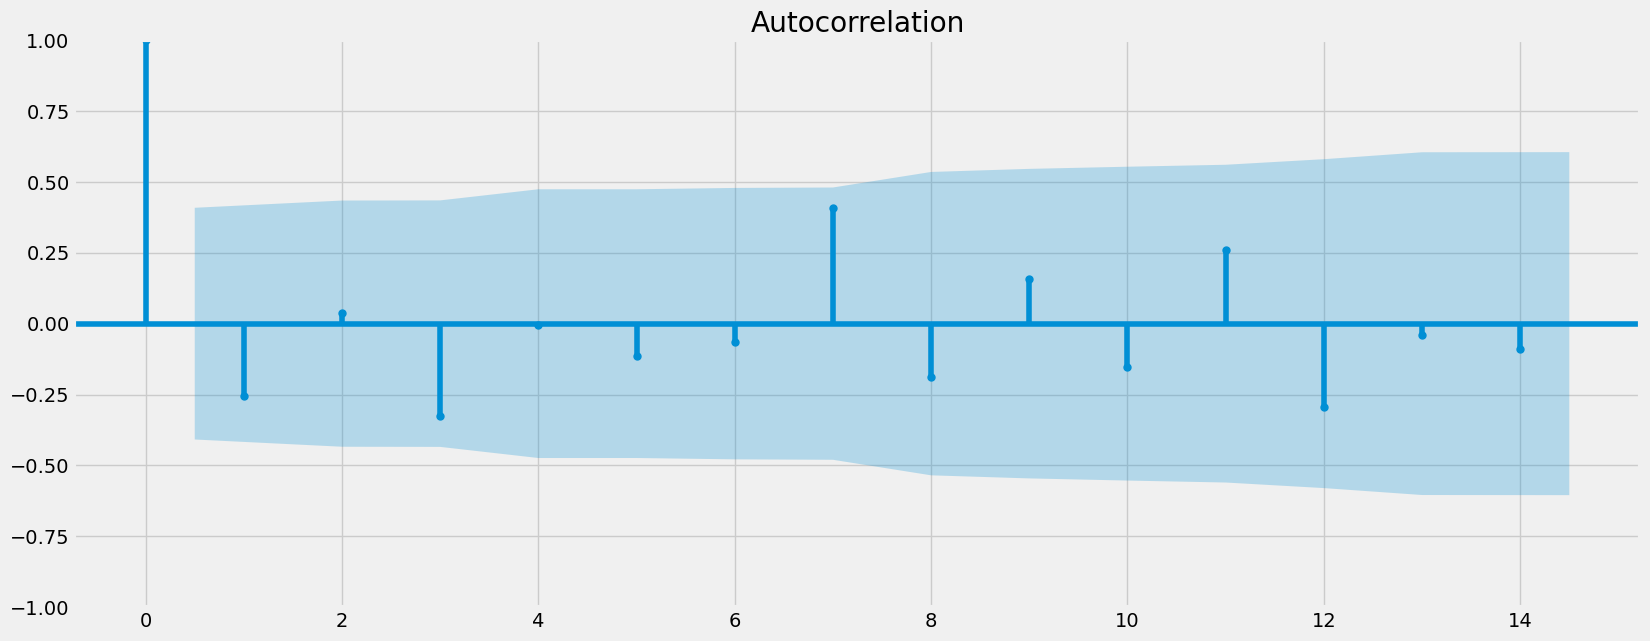

In [63]:
plot_acf(data_diff2)
plt.show()